In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2 

In [2]:
train = "/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Train"
test = "/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Test"
valid = "/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Validation"

In [3]:
train_gen = ImageDataGenerator(rescale=1./255.0,zoom_range=0.2,shear_range=0.2)
test_gen = ImageDataGenerator(rescale=1./255.0)
valid_gen = ImageDataGenerator(rescale=1./255.0)

In [4]:
train_ds = train_gen.flow_from_directory(train,target_size=(224,224),batch_size=32)
test_ds = test_gen.flow_from_directory(test,target_size=(224,224),batch_size=32)
valid_ds = valid_gen.flow_from_directory(valid,target_size=(224,224),batch_size=32)

Found 160000 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [5]:
def plot_data(ds,batch_num,image_num):
    plt.imshow(ds[batch_num][0][image_num])
    name = np.argmax(ds[batch_num][1][image_num])
    plt.xlabel(list(train_ds.class_indices)[name])

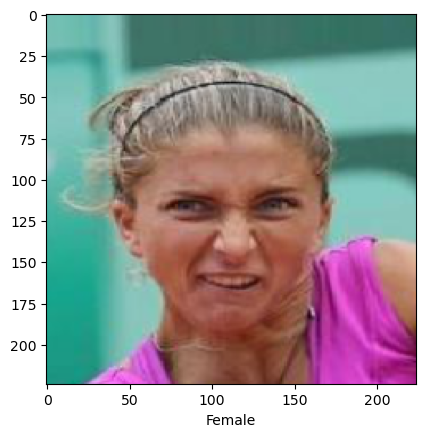

In [6]:
plot_data(train_ds,1,1)


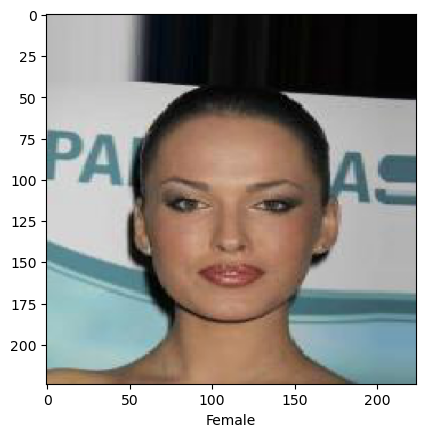

In [7]:
plot_data(test_ds,2,2)


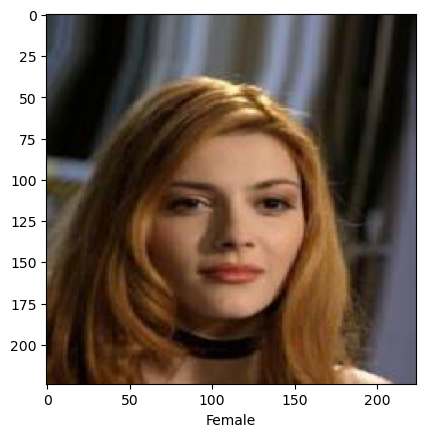

In [8]:
plot_data(valid_ds,2,30)


In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(input_shape=(224,224,3),include_top=False,weights="imagenet")
mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [10]:
mobilenet.trainable=True
for layer in mobilenet.layers[:-20]:
    layer.trainable=False

In [11]:
from keras import Sequential
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D

model = Sequential([mobilenet,
                   GlobalAveragePooling2D(),
                   BatchNormalization(),
                   Dense(256,activation='relu'),
                   BatchNormalization(),
                   Dense(2,activation='softmax')])

In [12]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])


In [13]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy' , patience=2 , restore_best_weights=True)]

In [15]:
history = model.fit(train_ds,epochs=5,batch_size=32,callbacks=callbacks,validation_data=valid_ds)


Epoch 1/5
5000/5000 [==============================] - 3163s 633ms/step - loss: 0.1393 - accuracy: 0.9463 - val_loss: 0.2140 - val_accuracy: 0.9496
Epoch 2/5
5000/5000 [==============================] - 2103s 421ms/step - loss: 0.0980 - accuracy: 0.9636 - val_loss: 0.1162 - val_accuracy: 0.9595
Epoch 3/5
5000/5000 [==============================] - 2089s 418ms/step - loss: 0.0806 - accuracy: 0.9699 - val_loss: 0.0932 - val_accuracy: 0.9673
Epoch 4/5
5000/5000 [==============================] - 2129s 426ms/step - loss: 0.0698 - accuracy: 0.9746 - val_loss: 0.0759 - val_accuracy: 0.9730
Epoch 5/5
5000/5000 [==============================] - 2112s 422ms/step - loss: 0.0629 - accuracy: 0.9768 - val_loss: 0.0814 - val_accuracy: 0.9711


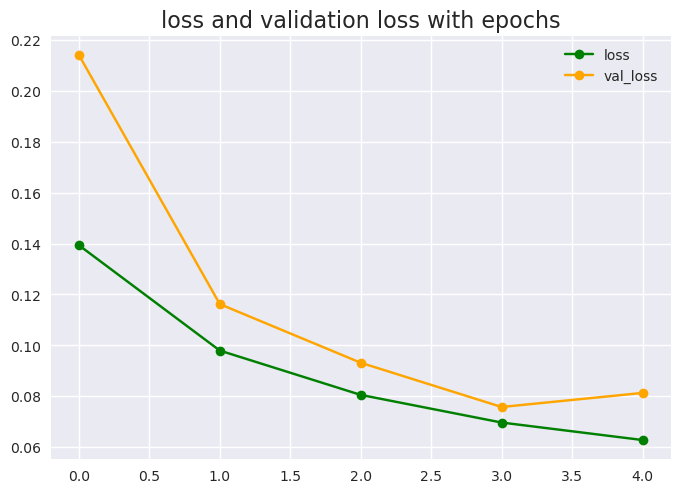

In [23]:
plt.style.use('seaborn')
plt.title('loss and validation loss with epochs', fontsize=16)
plt.plot(history.history['loss'], marker='o', color="green", label="loss")
plt.plot(history.history['val_loss'], marker='o',color="orange", label="val_loss")
plt.legend()
plt.show()

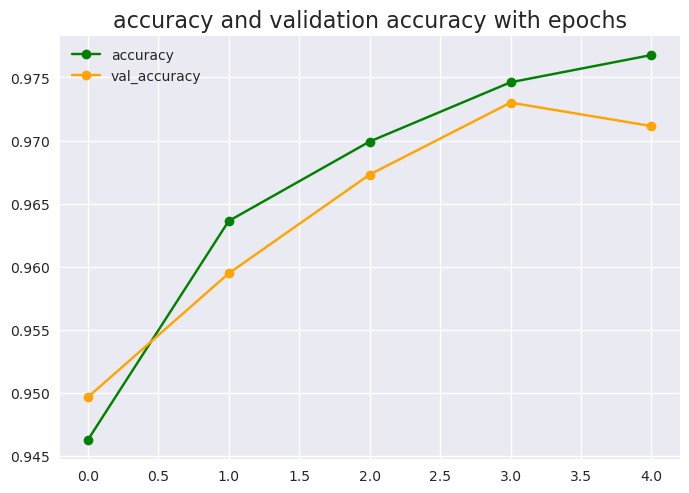

In [24]:
plt.title('accuracy and validation accuracy with epochs', fontsize=16)
plt.plot(history.history['accuracy'], marker='o', color="green", label="accuracy")
plt.plot(history.history['val_accuracy'], marker='o',color="orange", label="val_accuracy")
plt.legend()
plt.show()

In [18]:
my_own_model = model.save("gender classification", save_format="h5")

In [21]:
from tensorflow.keras.models import load_model
m = load_model('gender classification')

In [22]:
m.evaluate(test_ds)

626/626 [==============================] - 184s 292ms/step - loss: 0.0613 - accuracy: 0.9768


[0.061267804354429245, 0.9768011569976807]

In [26]:
results = model.predict(test_ds)
results.sum()

626/626 [==============================] - 55s 87ms/step


20001.0

In [2]:
def checking(img):
    label = {0:"female",1:"male"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier("/kaggle/input/test-model/haarcascade_frontalface_default.xml")
    faces = cascade.detectMultiScale(gray,1.1,7)#1.1
    
    for x,y,w,h in faces:
        face = image[y:y+h,x:x+w]
        face = cv2.resize(face,(150,150))
        img_scaled = face/255.0
        reshape = np.reshape(img_scaled,(1,150,150,3))
        img = np.vstack([reshape])
        result = (model.predict(img) > 0.5).astype("int32")

        
        if result == 0:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
            
            
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            
        
            
        elif result == 1:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
    plt.show()
    cv2.destroyAllWindows()

In [5]:
checking('/kaggle/input/gender-recognition-200k-images-celeba/Dataset/Test/Male/160008.jpg')

NameError: name 'model' is not defined